In [9]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

# Sampling a 2d correlated Gaussian

In [10]:
# Let's begin by obtaining some prior samples. I've chosen Unif(-1, 1) in all dimensions.

n = 2 # Number of dimensions.
n_prior = 10 # Number of prior samples
# Note the use of the key here. Jax uses this as opposed to your normal random seed. 
jax_prior_init = jax.random.uniform(key, shape=(n_prior, n), minval=-5, maxval=5)

In [11]:
'''
This is just a function to generate a covariance matrix for the Gaussian as a random sample from a Wishart
distribution, whilst ensuring the condition number is not too high.
'''
def get_icov(n, target=200, iseed=seed, eps=1, scale=50, just_do_it=False):
    condition = 0
    eigmax = np.inf
    this_seed = iseed
    if just_do_it:
        wish = scipy.stats.wishart(df=n, scale=np.eye(n)*scale, seed=this_seed)
        iC = wish.rvs(size=1)
        C = np.linalg.inv(iC)
        eigs = np.linalg.eigvals(C)
        eigmax,eigmin = eigs.max(), eigs.min()
        condition = eigmax / eigmin
    elif not just_do_it:
        while(abs(condition-target)>eps):
            wish = scipy.stats.wishart(df=n, scale=np.eye(n)*scale,seed=this_seed)
            iC = wish.rvs(size=1)
            C = np.linalg.inv(iC)
            eigs = np.linalg.eigvals(C)
            eigmax,eigmin = eigs.max(),eigs.min()
            condition = eigmax / eigmin
            this_seed += 1
    print("PSD: ",np.all(eigs>0))
    print("Condition number: ", condition)
    print("Op norm: ", eigmax)
    return iC, C

iCov, Cov = get_icov(n, eps=1)

PSD:  True
Condition number:  200.08339840534012
Op norm:  1.0242239245672016


In [12]:
'''
Define a function that returns the log-likelihood. First argument must be the variables you want to sample,
followed by any additional arguments.
'''
def log_like_cg(x, mu_diag=0, cov=Cov):
    n=x.shape[-1]
    mu = mu_diag * jnp.ones(n)
    return jax.scipy.stats.multivariate_normal.logpdf(x, mean=mu, cov=cov)
'''
Define a function that returns the log-prior. As before, the first argument must the the variables you want to 
sample, followed by any additional arguments.
'''
def log_flat_prior(x, lower=-5, upper=5):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc=lower, scale=upper-lower))

log_like_grad = jax.grad(log_like_cg)
log_prior_grad = jax.grad(log_flat_prior)

print(jax.vmap(lambda x: log_like_grad(x))(jax_prior_init))

[[-1.48657465e+01  1.93846176e+02]
 [-1.80558667e-01  6.57720184e+01]
 [-4.07183418e+01  5.94855347e+02]
 [ 1.40906725e+01 -1.95216339e+02]
 [-2.14719796e+00  5.01006355e+01]
 [ 6.63102646e+01 -9.63090454e+02]
 [ 6.54115057e+00 -1.38939484e+02]
 [ 2.88576622e+01 -4.52563873e+02]
 [-4.16364479e+01  6.22652344e+02]
 [-5.52799988e+01  8.22711121e+02]]


Below I have defined the key parameters that I think you will need to worry about. If you look at the actual code you'll see a lot more parameters. Some of these are from older versions of the algorithm, and some of these are only relevant for the NFO optimization algorithm. We'll tidy this up at some point, but this should be enough to get you going.

In [13]:
# General parameters
log_like_args = ()
log_prior_args = ()
prior_rvs_args = ()
vmap = True
parallel_backend = None
bounds = np.array([-5*np.ones(n), 5*np.ones(n)])
random_seed = seed

#sinf parameters
reg_alpha = (0., 0.98)
NBfirstlayer = True
verbose = False
interp_nbin = 5
sgd_steps = 0
gamma = 0
knots_trainable = None
optimize_directions = False
logp_cut = None
edge_bins = 0
Whiten = True
Whiten_with_weights = True
iteration = 5
NERCOME = True
frac_validate = 0.1
snf_loss = 3
reg = 0.0
reg1 = 1.0
reg2 = 1.0

'''
DLA parameters
'''
dla_step_size = 1.0
num_extra_dla_samples = 40
grad_norm_thresh = 0.5
max_dla_line_steps = 20
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
accelerate_dla = False
grad_free_dla = False
latent_dla = True
flow_type = 'SINF'
max_dla_iter = 9
maxknot = True

maf_layers = 10
maf_hidden = 5
maf_activation = torch.sigmoid
dropout_prob = 0.2
maf_epochs = 5000

mala_step_size = 1.0
num_mala = 0
tune_mala = 50

Now we can run our 10d Gaussian example.

In [14]:
trace = nfmc_jax.infer_dlmc(log_like_func=log_like_cg, 
                             log_prior_func=log_flat_prior,
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             frac_validate=frac_validate,
                             #sinf parameters
                             reg_alpha=reg_alpha,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             #SMC parameters
                             snf_loss=snf_loss,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             NERCOME=NERCOME,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             accelerate_dla=accelerate_dla,
                             latent_dla=latent_dla,
                             flow_type=flow_type,
                             max_dla_iter=max_dla_iter,
                             maf_layers=maf_layers,
                             maf_hidden=maf_hidden,
                             maf_activation=maf_activation,
                             dropout_prob=dropout_prob,
                             maf_epochs=maf_epochs,
                             mala_step_size=mala_step_size,
                             num_mala=num_mala,
                             tune_mala=tune_mala,
                             maxknot=maxknot)

bounds_sinf = [[-5.0, 5.0], [-5.0, 5.0]]
Time for prior DLA = 0.5161410909999944
Current logZ estimate = -3.768643617630005
Acceptance rate for MH adjustment: 0.3
Time for DLA MH adjustment = 0.17328826700000377
Time for latent space DLA = 0.7293463730000127
Current logZ estimate = -3.1315431594848633
Burnin stage 1, Fisher Divergence: 17843.25390625
Burnin stage 1, abs(norm(dlogq)/norm(dlogp)) = 0.8694484829902649
Gradient norms are comparable - ending burnin ...
Stage 1, Sample Mean: -0.4905925691127777
Stage 1, Sample Variance: 2.7445592880249023
Current logZ estimate = -3.7256999015808105
DLA stage 1, Latent Fisher Divergence: 79994.2578125
Primary DLA stage 1, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.1897328943014145
Acceptance rate for MH adjustment: 0.34
Time for DLA MH adjustment = 0.16770678000000316
Time for latent space DLA = 0.5573800850000055
Stage 2, Sample Mean: -0.44988444447517395
Stage 2, Sample Variance: 1.2675951719284058
Current logZ estimate = -4.407611846923828
DLA stage 

In [20]:
#f = open('./paper_experiments/latent_gaussian_2d_trace.pkl', 'wb')
#pickle.dump(trace, f)
#f.close()

In [21]:
q_models = trace['dla_q_models'][0]
q = q_models[list(q_models.keys())[-1]]
x = q.sample(10)
logq = q.logq(x)
z = q.forward(x)
logj_f = q.logj_forward(x)
xi = q.inverse(z)
logj_i = q.logj_backward(z)

print(f'x = {x}')
print(f'z = {z}')
print(f'xi = {xi}')
print(f'logj_f = {logj_f}')
print(f'logj_i = {logj_i}')

x = tensor([[ 4.0755e-01,  6.1276e-02],
        [-2.8146e+00, -7.4931e-01],
        [ 2.6218e-02,  2.4915e-03],
        [-6.1751e-01, -1.0641e+00],
        [-2.5501e-01,  8.9765e-03],
        [ 2.8298e-01,  2.7506e-02],
        [-1.8670e+00, -1.5076e-01],
        [ 3.3417e-01, -1.7536e-02],
        [ 2.7922e-01, -6.7249e-02],
        [-2.0179e+00, -3.7523e-01]])
z = tensor([[-0.8484, -0.5715],
        [ 2.2696, -0.2093],
        [-0.0429,  0.1089],
        [ 1.5073,  1.8923],
        [ 0.1361, -0.4320],
        [-0.4266,  0.0379],
        [ 1.6329, -0.1637],
        [-0.1723,  0.9223],
        [ 0.2380,  1.8133],
        [ 1.7835, -0.0140]])
xi = tensor([[ 4.0755e-01,  6.1276e-02],
        [-2.8146e+00, -7.4931e-01],
        [ 2.6218e-02,  2.4915e-03],
        [-6.1751e-01, -1.0641e+00],
        [-2.5501e-01,  8.9765e-03],
        [ 2.8298e-01,  2.7506e-02],
        [-1.8670e+00, -1.5076e-01],
        [ 3.3417e-01, -1.7536e-02],
        [ 2.7922e-01, -6.7249e-02],
        [-2.0179e+00,

The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [22]:
# Check the dictionary keys.
trace.keys()

dict_keys(['final_q_samples', 'final_qw_weights', 'log_evidence', 'mh_samples', 'dla_samples', 'mh_logp', 'mh_logq', 'mh_dlogp', 'mh_dlogq', 'dla_logZ', 'dla_q_models', 'dla_qw_models'])

In [23]:
   # Function for plotting up the samples in a corner plot.

def plot_triangles(samples, weights, Cov, Ngd=1000, beta_idx=None,
                   out_name=None):

    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]
    
    truth = n_mvn.rvs(mean=np.zeros(n), cov=Cov, size=Ngd)
    truth_gd = MCSamples(samples=truth,names = names, labels = labels, label='truth')

    samples_w = MCSamples(samples=samples, weights=weights,
                          names=names, labels=labels, 
                          label='posterior samples')

    # Triangle plot
    plt.figure()
    g = plots.get_subplot_plotter()
    g.triangle_plot([truth_gd, samples_w], filled=True)
    plt.show()
    if out_name is not None:
        g.export(out_name)

In [24]:
# First plot the samples without weights.
q_samples = np.asarray(trace['final_q_samples'][0])
q_weights = np.asarray(trace['final_qw_weights'][0])

Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

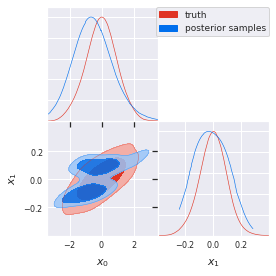

In [25]:
plot_triangles(q_samples, q_weights, Cov)

In [26]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

      labels     $x_0$     $x_1$
0          q -1.618149 -0.083591
1          q -0.506520 -0.049538
2          q -2.359599 -0.154897
3          q -0.971747 -0.019974
4          q  0.065687 -0.069169
...      ...       ...       ...
10045      T  0.510988  0.046074
10046      T -0.537798 -0.032829
10047      T  2.209297  0.193357
10048      T  2.174354  0.092499
10049      T -1.300648 -0.008011

[10050 rows x 3 columns]


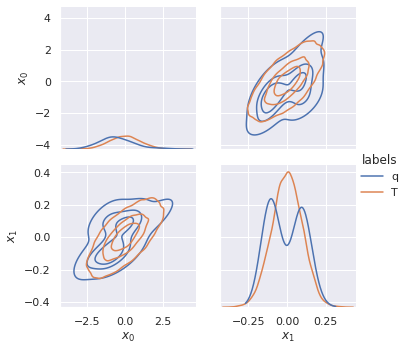

In [27]:
truth = n_mvn.rvs(mean=np.zeros(n), cov=Cov, size=10000)
sns_pairplot(q_samples, q_weights, truth, levels=4, out_name='./final_weighted_q_dla.png')

      labels     $x_0$     $x_1$
0          q -1.618149 -0.083591
1          q -0.506520 -0.049538
2          q -2.359599 -0.154897
3          q -0.971747 -0.019974
4          q  0.065687 -0.069169
...      ...       ...       ...
10045      T  0.510988  0.046074
10046      T -0.537798 -0.032829
10047      T  2.209297  0.193357
10048      T  2.174354  0.092499
10049      T -1.300648 -0.008011

[10050 rows x 3 columns]


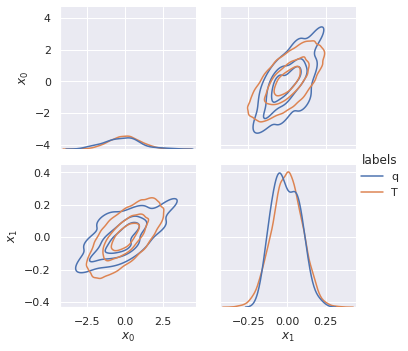

In [28]:
sns_pairplot(q_samples, np.ones(len(q_samples)), truth, levels=4, 
             out_name='./final_unweighted_q_dla.png')

In [29]:
dla_samples = trace['mh_samples'][0]
dla_samples.keys()

dict_keys(['init_0', 'burnin_0', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'fDLA_10'])

      labels     $x_0$     $x_1$
0          q  0.133650 -0.034352
1          q -0.371177  0.035322
2          q -1.706188 -0.178376
3          q  0.358271  0.032121
4          q  1.061876 -0.004712
...      ...       ...       ...
10045      T  0.510988  0.046074
10046      T -0.537798 -0.032829
10047      T  2.209297  0.193357
10048      T  2.174354  0.092499
10049      T -1.300648 -0.008011

[10050 rows x 3 columns]


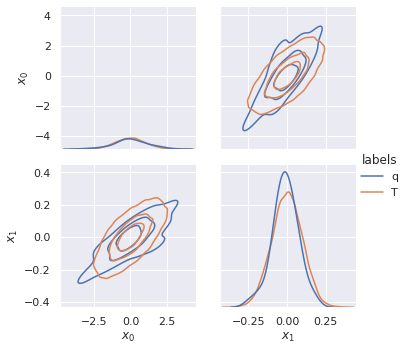

In [30]:
fkey = list(dla_samples.keys())[-1]
fkey = 'DLA_3'
sns_pairplot(dla_samples[fkey], np.ones(len(dla_samples[fkey])), truth, levels=4)

# Nice plots for visualizing the DLA updates ...

In [213]:
dla_samples = trace['dla_samples'][0]
mh_samples = trace['mh_samples'][0]
truth = n_mvn.rvs(mean=np.zeros(n), cov=Cov, size=10000)

In [214]:
def quiver_plot(init_samples, dla_updates, mh_updates=None, truth=None, q_samples=None, levels=4, out_name=None,
                figsize=(2 * 4, 2 * 2.5), markersize=10, max_samples=10, legend=False, xlim=None, ylim=None,
                q_bw=0.4):
    
    plt.figure(figsize=figsize)
    sns.set_theme()
    
    if truth is not None:
        sns.kdeplot(truth[:, 0], truth[:, 1], label='Target', alpha=0.5, color='#CC3311', levels=levels, bw=0.5)
    if q_samples is not None:
        sns.kdeplot(q_samples[:, 0], q_samples[:, 1], label='q', alpha=0.5, color='#0077BB', levels=levels,
                    bw=q_bw, clip=((-5, 5), (-5, 5)))
        
    init_samples = init_samples[:max_samples]
    dla_updates = dla_updates[:max_samples]
    if mh_updates is not None:
        mh_updates = mh_updates[:max_samples]
    
    if mh_updates is not None:
        dla_diff = dla_updates - mh_updates
        mh_changed = np.where(init_samples != mh_updates)[0]
        mh_updated = mh_updates[mh_changed]
        mh_diff = mh_updated - init_samples[mh_changed]
    else:
        dla_diff = dla_updates - init_samples
    
    sns.scatterplot(init_samples[:, 0], init_samples[:, 1], label='Initial Positions', 
                    color='#332288', marker="o", s=markersize)
    sns.scatterplot(dla_updates[:, 0], dla_updates[:, 1], label='DLA updates', 
                    color='#117733', marker="v", s=markersize)
    
    if mh_updates is not None:
        sns.scatterplot(mh_updated[:, 0], mh_updated[:, 1], label='MH updates', 
                        color='#999933', marker="D", s=markersize)
        
        plt.quiver(mh_updates[:, 0], mh_updates[:, 1], 
                   dla_diff[:, 0], dla_diff[:, 1], angles='xy',
                   alpha=0.5, scale_units='xy', scale=1, color='#88CCEE', label='DLA vector')
        
        plt.quiver(init_samples[:, 0][mh_changed], init_samples[:, 1][mh_changed], 
                   mh_diff[:, 0], mh_diff[:, 1], angles='xy', alpha=0.5, 
                   scale_units='xy', scale=1, color='#44AA99', label='MH vector')
    else:
        plt.quiver(init_samples[:, 0], init_samples[:, 1], 
                   dla_diff[:, 0], dla_diff[:, 1], angles='xy',
                   alpha=0.5, scale_units='xy', scale=1, color='#88CCEE', label='DLA vector')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    if legend:
        sns.scatterplot(-10*np.ones(10), -10*np.ones(10), color='#999933', marker="D", 
                        s=markersize, label='MH updates')
        plt.quiver(-10, -10, 
                   1, 1, angles='xy', alpha=0.5, 
                   scale_units='xy', scale=1, color='#44AA99', label='MH vector')
        sns.kdeplot(np.random.normal(size=10)+100, np.random.normal(size=10)+100, label='q', alpha=0.5, 
                    color='#0077BB', levels=levels, bw=q_bw)
        plt.legend(loc='upper right')
    else:
        plt.legend('', frameon=False)
    if out_name is not None:
        plt.savefig(out_name, bbox_inches='tight')

/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/h

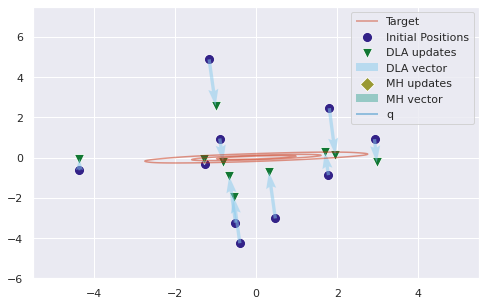

In [179]:
quiver_plot(jax_prior_init, dla_samples['init_0'], None,
            truth, markersize=100, legend=True, xlim=(-5.5, 5.5), ylim=(-6, 7.5))
            #out_name='./dla_figs/paper/gaussian_2d_init_0_dla_update.png')

In [158]:
idx = np.random.choice(50, 10, replace=False)
idx = np.array([1, 5, 11, 15, 20, 25, 30, 35, 40, 45])

f = open('./dla_figs/paper/latent_2d_gauss_trace.pkl', 'rb')
latent_trace = pickle.load(f)
f.close()
f = open('./dla_figs/paper/data_2d_gauss_trace.pkl', 'rb')
data_trace = pickle.load(f)
f.close()

dict_keys(['init_0', 'burnin_0', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'fDLA_10'])


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

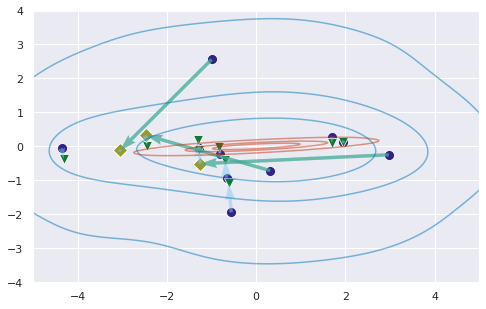

In [215]:
key = 'burnin_0'
init_key = 'init_0'
idx = np.arange(10)

print(dla_samples.keys())

q = trace['dla_q_models'][0][key]
qx = q.sample(2000, device='cpu')
qx = qx.detach().numpy()
mag = np.linalg.norm(qx, axis=1)

quiver_plot(dla_samples[init_key][idx], dla_samples[key][idx], mh_samples[key][idx], truth, qx, markersize=100,
            q_bw=0.5, ylim=(-4, 4), xlim=(-5., 5.),
            out_name=f'./dla_figs/paper/new_data_2d_gaussian_{key}.png')

In [85]:
dla_keys = list(dla_samples.keys())
mh_keys = list(mh_samples.keys())
print(dla_keys)
print(mh_keys)

['init_0', 'burnin_0', 'burnin_1', 'burnin_2', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'fDLA_10']
['init_0', 'burnin_0', 'burnin_1', 'burnin_2', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'fDLA_10']


init_key = prior
Current key = init_0
shape init = (10, 2)
shape dla = (10, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/h

init_key = init_0
Current key = burnin_0
shape init = (10, 2)
shape dla = (10, 2)
shape mh = (10, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

init_key = DLA_1
Current key = DLA_2
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

init_key = DLA_2
Current key = DLA_3
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

init_key = DLA_3
Current key = DLA_4
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

init_key = DLA_4
Current key = DLA_5
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

init_key = DLA_5
Current key = DLA_6
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

init_key = DLA_6
Current key = DLA_7
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

init_key = DLA_7
Current key = DLA_8
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

init_key = DLA_8
Current key = DLA_9
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

init_key = DLA_9
Current key = DLA_10
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

init_key = DLA_10
Current key = fDLA_10
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home

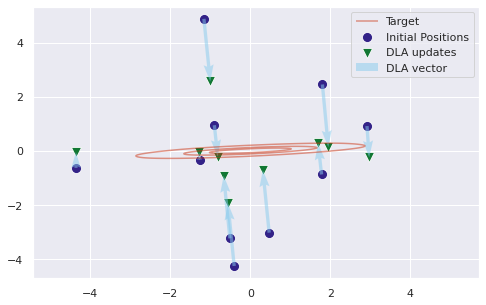

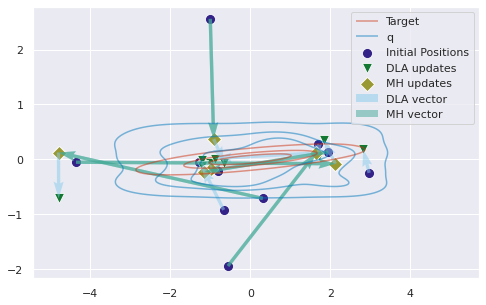

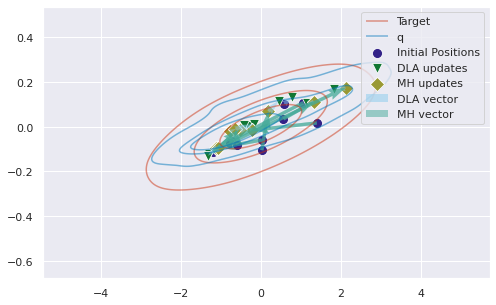

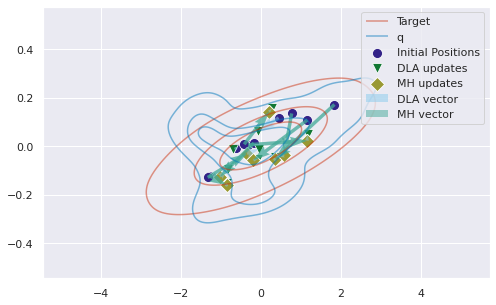

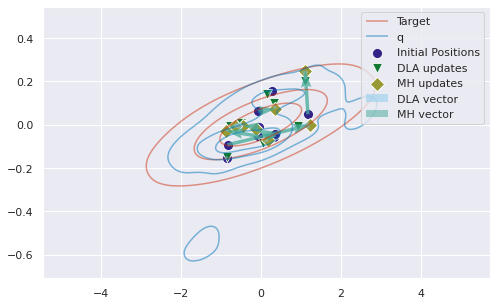

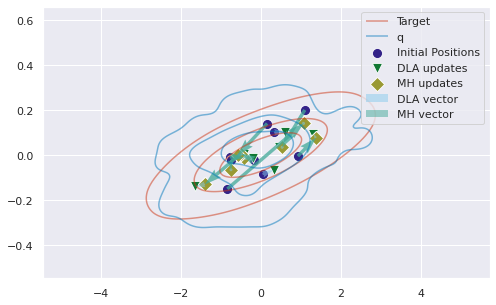

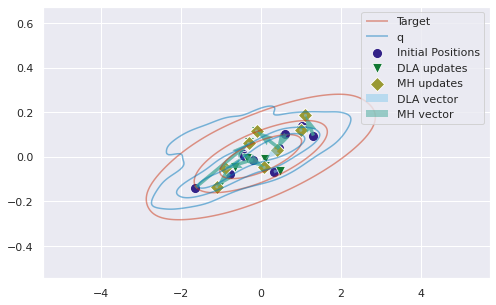

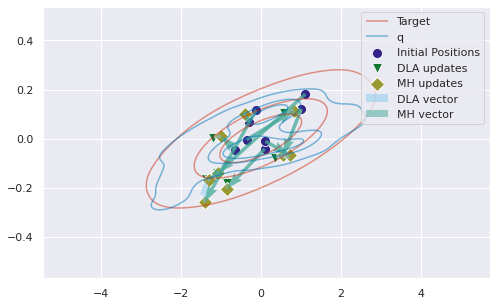

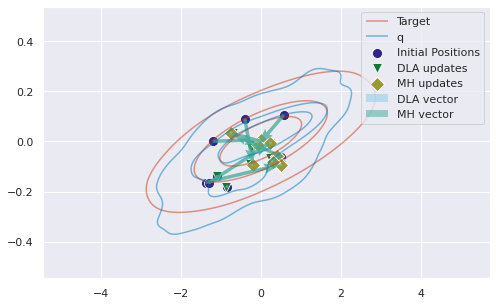

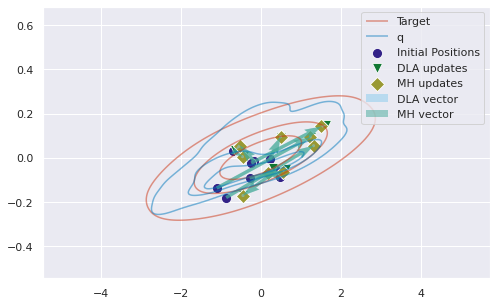

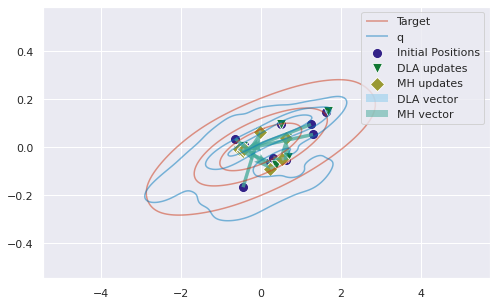

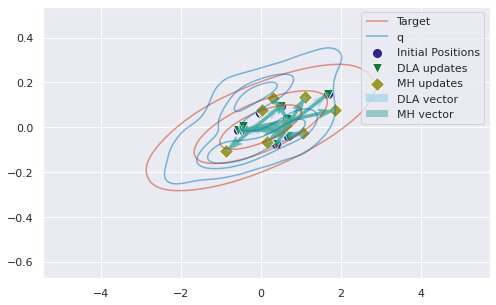

In [34]:


dla_samples = latent_trace['dla_samples'][0]
mh_samples = latent_trace['mh_samples'][0]
dla_keys = list(dla_samples.keys())



for i, key in enumerate(dla_keys):
    
    if key == 'post_burnin_0' or dla_keys[i - 1] == 'post_burnin_0':
        continue
    
    if i == 0:
        print('init_key = prior')
        initial_samples = jax_prior_init
    elif i > 0:
        print(f'init_key = {dla_keys[i - 1]}')
        initial_samples = dla_samples[dla_keys[i - 1]]

    print(f'Current key = {key}')
    dla_updates = dla_samples[key]
    mh_updates = mh_samples[key]
    if key == 'init_0':
        mh_updates = None
    
    print(f'shape init = {np.shape(initial_samples)}')
    print(f'shape dla = {np.shape(dla_updates)}')
    if mh_updates is not None:
        print(f'shape mh = {np.shape(mh_updates)}')
    
    q = trace['dla_q_models'][0][key]
    qx = q.sample(2000, device='cpu')
    qx = qx.detach().numpy()
    mag = np.linalg.norm(qx, axis=1)
    if key != 'burnin_0':
        qx = qx[np.abs(qx[:, 0]) < 3.]
        qx = qx[np.abs(qx[:, 1]) < 0.6]
    
    if key == 'init_0':
        qx = None
    
    quiver_plot(initial_samples, dla_updates, mh_updates, truth, qx, markersize=100,
                levels=4, out_name=f'./dla_figs/paper/data_dla_iteration_{key}.png')

# Check q fits ...

In [ ]:
def create_flow(self, samples, weights):
        
    """Create the flow being used to surrogate the target density."""
    if self.flow_type == 'SINF':

            if self.frac_validate > 0.0:
                num_val = int(self.frac_validate * samples.shape[0])
                val_idx = jax.random.choice(self.jax_key, jnp.arange(samples.shape[0]), shape=(num_val,), replace=False)
                fit_idx = jnp.delete(jnp.arange(samples.shape[0]), val_idx)
                self.gis_kwargs['data_validate'] = torch.tensor(np.asarray(samples[val_idx]), dtype=torch.float32)
                self.gis_kwargs['weight_validate'] = torch.tensor(np.asarray(weights[val_idx]), dtype=torch.float32)
            elif self.frac_validate == 0.0:
                fit_idx = jnp.arange(len(samples))

            self.NFlow = SNFInterface(device=self.device,
                                      gis_kwargs=self.gis_kwargs,
                                      optimize_sinf_kwargs=self.optimize_sinf_kwargs)

            self.NFlow.create_flow(x_train=torch.tensor(np.asarray(samples[fit_idx]), dtype=torch.float32),
                                   weights=torch.tensor(np.asarray(weights[fit_idx]), dtype=torch.float32))

        elif self.flow_type == 'MAF':

            self.NFlow = MAFInterface(n_dim=self.ndim,
                                      n_layers=self.maf_layers,
                                      n_hidden=self.maf_hidden,
                                      activation=self.maf_activation,
                                      dropout_prob=self.dropout_prob,
                                      device=self.device)
            self.NFlow.create_flow()

    def train_flow(self, samples, weights, logp=None):
        """Train the flow being used to surrogate the target density."""
        if self.flow_type == 'SINF':
            if logp is None:
                raise ValueError('For flow_type SINF, you must supply logp of training samples.')
            self.NFlow.train_flow(x=torch.tensor(np.asarray(samples), dtype=torch.float32),
                                  logp=torch.tensor(np.asarray(logp), dtype=torch.float32),
                                  weights=torch.tensor(np.asarray(weights), dtype=torch.float32))
        elif self.flow_type == 'MAF':
            self.NFlow.train_flow(x=torch.tensor(np.asarray(samples), dtype=torch.float32),
                                  n_epochs=self.maf_epochs,
                                  weights=torch.tensor(np.asarray(weights), dtype=torch.float32))

        logq = self.NFlow.logq(torch.tensor(np.asarray(samples), dtype=torch.float32))

        return self.NFlow, jnp.asarray(logq.detach().numpy())

# Joint plots ...

In [40]:
def joint_quiver_plot(init_samples, dla_updates, mh_updates=None, truth=None, 
                      q_samples=None, levels=4, out_name=None,
                      figsize=(2 * 4, 2 * 2.5), markersize=10):
    
    """Pass all the samples arguments (apart from truth) as tuples in order (data space, latent space)."""
    
    if mh_updates is not None:
        dla_diff = dla_updates - mh_updates
        mh_changed = np.where(init_samples != mh_updates)[0]
        mh_updated = mh_updates[mh_changed]
        mh_diff = mh_updated - init_samples[mh_changed]
    else:
        dla_diff = dla_updates - init_samples
    
    plt.figure(figsize=figsize)
    sns.set_theme()
    sns.scatterplot(init_samples[:, 0], init_samples[:, 1], label='Initial Positions', color='#332288',
                    marker="o", s=markersize)
    sns.scatterplot(dla_updates[:, 0], dla_updates[:, 1], label='DLA updates', color='#117733',
                    marker="v", s=markersize)
    
    if mh_updates is not None:
        sns.scatterplot(mh_updated[:, 0], mh_updated[:, 1], label='MH updates', color='#999933',
                        marker="D", s=markersize)
        plt.quiver(mh_updates[:, 0], mh_updates[:, 1], dla_diff[:, 0], dla_diff[:, 1], angles='xy',
                   alpha=0.5, scale_units='xy', scale=1, color='#88CCEE', label='DLA vector')
        plt.quiver(init_samples[:, 0][mh_changed], init_samples[:, 1][mh_changed], mh_diff[:, 0], 
                   mh_diff[:, 1], angles='xy', alpha=0.5, scale_units='xy', scale=1, color='#44AA99', 
                   label='MH vector')
    else:
        plt.quiver(init_samples[:, 0], init_samples[:, 1], dla_diff[:, 0], dla_diff[:, 1], angles='xy',
                   alpha=0.5, scale_units='xy', scale=1, color='#88CCEE', label='DLA vector')
        
    if truth is not None:
        sns.kdeplot(truth[:, 0], truth[:, 1], label='Target', alpha=0.5, color='#CC3311', levels=levels)
    if q_samples is not None:
        sns.kdeplot(q_samples[:, 0], q_samples[:, 1], label='q', alpha=0.5, color='#0077BB', levels=levels)
    plt.legend(loc=2, bbox_to_anchor=(1, 1))
    
    
    if out_name is not None:
        plt.savefig(out_name, bbox_inches='tight')

# Tidied plots ...

In [30]:
def ax_quiver_plot(ax, init_samples, dla_updates, mh_updates=None, truth=None, q_samples=None, levels=4, 
                   markersize=10, max_samples=10):
    
    sns.set_theme()
    
    if truth is not None:
        sns.kdeplot(truth[:, 0], truth[:, 1], label='Target', alpha=0.5, color='#CC3311', levels=levels, 
                    bw=0.6, ax=ax)
    if q_samples is not None:
        sns.kdeplot(q_samples[:, 0], q_samples[:, 1], label='q', alpha=0.5, color='#0077BB', levels=levels,
                    ax=ax)
        
    init_samples = init_samples[:max_samples]
    dla_updates = dla_updates[:max_samples]
    if mh_updates is not None:
        mh_updates = mh_updates[:max_samples]
    
    if mh_updates is not None:
        dla_diff = dla_updates - mh_updates
        mh_changed = np.where(init_samples != mh_updates)[0]
        mh_updated = mh_updates[mh_changed]
        mh_diff = mh_updated - init_samples[mh_changed]
    else:
        dla_diff = dla_updates - init_samples
    
    sns.scatterplot(init_samples[:, 0], init_samples[:, 1], label='Initial Positions', 
                    color='#332288', marker="o", s=markersize, ax=ax)
    sns.scatterplot(dla_updates[:, 0], dla_updates[:, 1], label='DLA updates', 
                    color='#117733', marker="v", s=markersize, ax=ax)
    
    if mh_updates is not None:
        sns.scatterplot(mh_updated[:, 0], mh_updated[:, 1], label='MH updates', 
                        color='#999933', marker="D", s=markersize, ax=ax)
        
        ax.quiver(mh_updates[:, 0], mh_updates[:, 1], 
                   dla_diff[:, 0], dla_diff[:, 1], angles='xy',
                   alpha=0.5, scale_units='xy', scale=1, color='#88CCEE', label='DLA vector')
        
        ax.quiver(init_samples[:, 0][mh_changed], init_samples[:, 1][mh_changed], 
                   mh_diff[:, 0], mh_diff[:, 1], angles='xy', alpha=0.5, 
                   scale_units='xy', scale=1, color='#44AA99', label='MH vector')
    else:
        ax.quiver(init_samples[:, 0], init_samples[:, 1], 
                   dla_diff[:, 0], dla_diff[:, 1], angles='xy',
                   alpha=0.5, scale_units='xy', scale=1, color='#88CCEE', label='DLA vector')

In [31]:
f = open('./dla_figs/paper/latent_2d_gauss_trace.pkl', 'rb')
latent_trace = pickle.load(f)
f.close()
f = open('./dla_figs/paper/data_2d_gauss_trace.pkl', 'rb')
data_trace = pickle.load(f)
f.close()

latent_dla_keys = list(latent_trace['dla_samples'][0].keys())

latent_select = ['init_0', 'burnin_0', 'burnin_2', 'DLA_4']
latent_init_key = [None, 'init_0', 'burnin_1', 'DLA_3']
latent_qx = []
latent_dla_samples = []
latent_mh_samples = []
latent_init_samples = []

for i, k in enumerate(latent_select):

    q = latent_trace['dla_q_models'][0][k]
    qx = q.sample(2000, device='cpu')
    qx = qx.detach().numpy()
    latent_qx.append(qx)
    
    latent_dla_samples.append(latent_trace['dla_samples'][0][k])
    if k == 'init_0':
        latent_mh_samples.append(None)
        latent_init_samples.append(jax_prior_init)
    else:
        latent_mh_samples.append(latent_trace['mh_samples'][0][k])
        latent_init_samples.append(latent_trace['dla_samples'][0][latent_init_key[i]])

data_dla_samples = data_trace['dla_samples'][0]
data_mh_samples = data_trace['mh_samples'][0]
data_dla_keys = list(data_dla_samples.keys())

data_select = ['burnin_0']
data_init_key = ['init_0']
data_qx = []
data_dla_samples = [data_trace['dla_samples'][0][data_select[0]]]
data_mh_samples = [data_trace['mh_samples'][0][data_select[0]]]
data_init_samples = [data_trace['dla_samples'][0][data_init_key[0]]]

q = data_trace['dla_q_models'][0][k]
qx = q.sample(2000, device='cpu')
qx = qx.detach().numpy()
data_qx.append(qx)

#fig, axlist = plt.subplots(2, 2, figsize=(3.6 * 2, 3.6 * 2))


KeyError: 'burnin_2'